In [127]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import optuna
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
#import tensorflow_addons as tfa
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from scipy.signal import savgol_filter
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [128]:
import sys
print(sys.version)

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]


In [129]:
import numpy as np
import pandas as pd
import math  # math is part of Python's standard library and does not have a version.
import seaborn as sns
import xgboost as xgb
import optuna
import time  # time is part of Python's standard library and does not have a version.
import matplotlib
import plotly
import tensorflow as tf
from keras import __version__ as keras_version
from sklearn import __version__ as sklearn_version
import statsmodels
from scipy import __version__ as scipy_version

# Print the versions
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("XGBoost version:", xgb.__version__)
print("Optuna version:", optuna.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Plotly version:", plotly.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras_version)
print("Scikit-learn version:", sklearn_version)
print("Statsmodels version:", statsmodels.__version__)
print("SciPy version:", scipy_version)


NumPy version: 1.26.4
Pandas version: 2.1.4
Seaborn version: 0.13.2
XGBoost version: 2.1.1
Optuna version: 4.1.0
Matplotlib version: 3.9.2
Plotly version: 5.24.0
TensorFlow version: 2.17.0
Keras version: 3.5.0
Scikit-learn version: 1.5.1
Statsmodels version: 0.14.2
SciPy version: 1.14.1


## define the funcitons

In [130]:
def preprocess_data(df):
    Datetime = pd.date_range(start='01/01/2021', periods=35040, freq='h')
    df['Datetime'] = Datetime

    df.set_index('Datetime', inplace=True)

    df.index = pd.to_datetime(df.index)


    return df

In [131]:
# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):
    
    print('Number of Nans in each column :')
    
    print(df_input.isnull().sum())
    print()
    print(f'Number of duplicates in the dataframe : {df_input.duplicated().sum()}')
    return

In [132]:
def preprocess_data(df):
    # Creating Datetime index
    Datetime = pd.date_range(start='01/01/2021', periods=35040, freq='h')
    df['time'] = Datetime

    # Setting Date as the index
    df.set_index('time', inplace=True)

    # Converting the index to a time series
    df.index = pd.to_datetime(df.index)


    return df

In [133]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    
    return plt.show()

In [134]:
def replace_outliers(df):
    for column in df.columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        median = df[column].median()
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median, df[column])
    return df

In [135]:
def apply_PCA(X_input, cum_variance, if_apply):
    
    if if_apply:
    
        pca = PCA(n_components = cum_variance)
        # make pipeline to first standardize then apply PCA on data
        scaler_pca = make_pipeline(MinMaxScaler(), pca)
        X_pca = scaler_pca.fit(X_input).transform(X_input)

        return X_pca
    
    else:
        
        return np.array(X_input)

In [136]:
def windowing(X_input, y_input, history_size, horizon_size):
    data = []
    labels = []
    
    # Loop to create windows of input data and corresponding target values
    for i in range(history_size, len(y_input) - horizon_size + 1):
        # Collect past 'history_size' values for input
        data.append(X_input[i - history_size : i, :])
        
        # Collect next 'horizon_size' values for target
        labels.append(y_input[i : i + horizon_size])
        
    # Convert lists to NumPy arrays for efficient processing
    return np.array(data), np.array(labels)


In [137]:
def reshaping(X):
    
    reshaped_x = X.reshape(-1 , X.shape[1] * X.shape[2])
    return reshaped_x

In [138]:
def plot_results_xgboost(y_pred_actual, y_test_inv, evals_result, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    # Plot the predicted vs actual values
    ax[0].plot(y_pred_actual[:24*30])  # Adjust this range based on your data size
    ax[0].plot(y_test_inv[:24*30])  # Adjust this range based on your data size
    ax[0].legend(['Prediction', 'Actual'], loc='upper left')
    ax[0].set_xlabel('Time Period')
    ax[0].set_ylabel('Electricity Energy Consumption [kWh]')
    
    # Plot training and validation MAE from evals_result dictionary
    train_mae = evals_result['train']['mae']
    val_mae = evals_result['eval']['mae']
    ax[1].plot(train_mae, label='Training MAE')
    ax[1].plot(val_mae, label='Validation MAE')

    ax[1].legend()
    ax[1].set_title(f'Training and Validation MAE ({model_name})')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('MAE')    

    fig.tight_layout()
    plt.show()

In [202]:
## Plot Function for Random and LSTM:: 
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    ax[0].plot(y_pred_actual[:24*30])
    ax[0].plot(y_test_inv[:24*30])
    ax[0].legend(['Prediction', 'Actual'], loc='upper left')
    ax[0].set_xlabel('Time Period')
    ax[0].set_ylabel('Electricity Energy Consumption [kWh]')
    
    if model != 'hybrid':
    
        if model_name == 'XGBoost':

            train_mae = model.evals_result()['validation_0']['mae']
            val_mae = model.evals_result()['validation_1']['mae']
            ax[1].plot(train_mae, label='Training MAE')
            ax[1].plot(val_mae, label='Validation MAE')

        else:

            ax[1].plot(history.history['loss'], label='Training Loss')
            ax[1].plot(history.history['val_loss'], label='Validation Loss')

        ax[1].legend()
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')    
        
    fig.tight_layout()
    plt.show()
    

In [140]:
url= 'https://raw.githubusercontent.com/Forbu/CityLearn-1.3.5/main/citylearn/data/citylearn_challenge_2021/'

In [141]:
#Read csv files
df_b1 = pd.read_csv(f"{url}Building_1.csv")
df_b2 = pd.read_csv(f"{url}Building_2.csv")
df_b3 = pd.read_csv(f"{url}Building_3.csv")
df_b4 = pd.read_csv(f"{url}Building_4.csv")
df_b5 = pd.read_csv(f"{url}Building_7.csv")
df_b6 = pd.read_csv(f"{url}Building_6.csv")
df_b7 = pd.read_csv(f"{url}Building_5.csv")
df_b8 = pd.read_csv(f"{url}Building_8.csv")
df_b9 = pd.read_csv(f"{url}Building_9.csv")

df_weather = pd.read_csv(f"{url}weather.csv")
df_carbon = pd.read_csv(f"{url}carbon_intensity.csv")

In [142]:
df_b5.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,35040.0,6.526027,3.447901,1.00,4.0000,7.00,10.00,12.00
Hour,35040.0,12.500000,6.922285,1.00,6.7500,12.50,18.25,24.00
Day Type,35040.0,4.102055,2.075291,1.00,2.0000,4.00,6.00,8.00
Daylight Savings Status,35040.0,0.654795,0.475442,0.00,0.0000,1.00,1.00,1.00
Indoor Temperature [C],35040.0,22.993908,0.289487,21.47,23.0400,23.11,23.12,23.80
Average Unmet Cooling Setpoint Difference [C],35040.0,0.004644,0.026944,0.00,0.0000,0.00,0.00,0.68
Indoor Relative Humidity [%],35040.0,50.903065,11.461393,10.57,44.7975,54.24,59.15,73.49
Equipment Electric Power [kWh],35040.0,13.581727,3.566894,3.70,11.0000,13.40,15.90,29.30
DHW Heating [kWh],35040.0,3.805366,4.292800,0.00,1.0800,2.40,4.92,42.72
Cooling Load [kWh],35040.0,27.374083,15.211901,0.00,15.1700,28.34,39.27,63.91


In [143]:
df_b5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 12 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Month                                          35040 non-null  int64  
 1   Hour                                           35040 non-null  int64  
 2   Day Type                                       35040 non-null  int64  
 3   Daylight Savings Status                        35040 non-null  int64  
 4   Indoor Temperature [C]                         35040 non-null  float64
 5   Average Unmet Cooling Setpoint Difference [C]  35040 non-null  float64
 6   Indoor Relative Humidity [%]                   35040 non-null  float64
 7   Equipment Electric Power [kWh]                 35040 non-null  float64
 8   DHW Heating [kWh]                              35040 non-null  float64
 9   Cooling Load [kWh]                             350

In [144]:
# List of building dataframes
building_dataframes = [df_b1, df_b2, df_b3, df_b4, df_b5, df_b6, df_b7, df_b8, df_b9]

# Columns to be removed
col_names = ['Heating Load [kWh]', 'Solar Generation [W/kW]']

# Loop through each dataframe and drop the specified columns
for i, df in enumerate(building_dataframes):
    building_dataframes[i] = df.drop(col_names, axis=1)
# Unpack the updated dataframes
df_b1, df_b2, df_b3, df_b4, df_b5, df_b6, df_b7, df_b8, df_b9= building_dataframes

In [145]:
ratio_df = df.pct_change().dropna()


/tmp/ipykernel_197538/2400522225.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ratio_df = df.pct_change().dropna()


In [146]:
check_Nans_Dups(df_b5)

Number of Nans in each column :
Month                                            0
Hour                                             0
Day Type                                         0
Daylight Savings Status                          0
Indoor Temperature [C]                           0
Average Unmet Cooling Setpoint Difference [C]    0
Indoor Relative Humidity [%]                     0
Equipment Electric Power [kWh]                   0
DHW Heating [kWh]                                0
Cooling Load [kWh]                               0
dtype: int64

Number of duplicates in the dataframe : 0


In [147]:
building_dataframes = [df_b1, df_b2, df_b3, df_b4, df_b5, df_b6, df_b7, df_b8, df_b9,df_weather,df_carbon]

# Initialize an empty dictionary to store the processed energy data for each building
processed_energy_data = {}

# Loop over the dataframes and preprocess each
for i, df in enumerate(building_dataframes, start=1):
    processed_energy_data[f"df{i}_energy"] = preprocess_data(df)

In [148]:
df_b1.tail()

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh]
time,,,,,,,,,,
2024-12-30 19:00:00,12,20,1.0,0.0,19.87,0.0,40.65,9.28,0.0,0.0
2024-12-30 20:00:00,12,21,1.0,0.0,19.68,0.0,40.04,9.28,0.0,0.0
2024-12-30 21:00:00,12,22,1.0,0.0,19.47,0.0,39.47,9.28,0.0,0.0
2024-12-30 22:00:00,12,23,1.0,0.0,19.26,0.0,39.17,9.28,0.0,0.0
2024-12-30 23:00:00,12,24,1.0,0.0,19.06,0.0,38.40,9.28,0.0,0.0


In [149]:
col_drop_name = ['6h Prediction Outdoor Drybulb Temperature [C]', '12h Prediction Outdoor Drybulb Temperature [C]','24h Prediction Outdoor Drybulb Temperature [C]']
# col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon']
df_weather.drop(col_drop_name, axis = 1 , inplace = True)

In [150]:
df_weather.rename(columns={
        'Outdoor Drybulb Temperature [C]': f'OutdoorDrybulbTemperature',
        'Outdoor Relative Humidity [%]': f'OutdoorRelativeHumidity',
        'Diffuse Solar Radiation [W/m2]': f'DiffuseSolarRadiation',
        'Direct Solar Radiation [W/m2]': f'DirectSolarRadiation',
        '6h Prediction Outdoor Relative Humidity [%]': f'6hPrediction OutdoorRelativeHumidity',
        '12h Prediction Outdoor Relative Humidity [%]': f'12hPredictionOutdoorRelativeHumidity',
        '24h Prediction Outdoor Relative Humidity [%]': f'24hPredictionOutdoorRelativeHumidity',
        '6h Prediction Diffuse Solar Radiation [W/m2]': f'6hPredictionDiffuseSolarRadiation',
        '12h Prediction Diffuse Solar Radiation [W/m2]': f'12hPredictionDiffuseSolarRadiation',
        '24h Prediction Diffuse Solar Radiation [W/m2]': f'24hPredictionDiffuseSolarRadiation',
        '6h Prediction Direct Solar Radiation [W/m2]': f'6hPredictionDirectSolarRadiation',
        '12h Prediction Direct Solar Radiation [W/m2]': f'12hPredictionDirectSolarRadiation',
        '24h Prediction Direct Solar Radiation [W/m2]': f'24hPredictionDirectSolarRadiation',


    }, inplace=True)

## Remove the outlier

In [151]:
# List of building dataframes
building_dataframes = [df_b1, df_b2, df_b3, df_b4, df_b5, df_b6, df_b7, df_b8, df_b9, df_weather, df_carbon]

# Corresponding names for each dataframe (for clarity in processing, if needed)
building_names = [
    "Building 1", "Building 2", "Building 3", "Building 4", 
    "Building 5", "Building 6", "Building 7", "Building 8", 
    "Building 9", "Weather Data", "Carbon Data"
]

# Loop through each dataframe and apply replace_outliers function
for i, df in enumerate(building_dataframes):
    print(f"Processing {building_names[i]}...")  # Print the name of the dataframe being processed
    building_dataframes[i] = replace_outliers(df)  # Apply replace_outliers and update each dataframe in place
    building_dataframes[i] = building_dataframes[i].drop_duplicates()

# Now each dataframe in building_dataframes has had its outliers replaced.


Processing Building 1...
Processing Building 2...
Processing Building 3...
Processing Building 4...
Processing Building 5...
Processing Building 6...
Processing Building 7...
Processing Building 8...
Processing Building 9...
Processing Weather Data...
Processing Carbon Data...


In [152]:
df_1 = pd.concat([df_b1, df_weather, df_carbon], axis=1)
df_2 = pd.concat([df_b2, df_weather, df_carbon], axis=1)
df_3 = pd.concat([df_b3, df_weather, df_carbon], axis=1)
df_4 = pd.concat([df_b4, df_weather, df_carbon], axis=1)
df_5 = pd.concat([df_b5, df_weather, df_carbon], axis=1)
df_6 = pd.concat([df_b6, df_weather, df_carbon], axis=1)
df_7 = pd.concat([df_b7, df_weather, df_carbon], axis=1)
df_8 = pd.concat([df_b8, df_weather, df_carbon], axis=1)
df_9 = pd.concat([df_b9, df_weather, df_carbon], axis=1)

In [153]:
df_5 = df_5[df_5.index < '2024-01-01']

In [154]:
df_5.shape

(26280, 24)

In [155]:
df_5.columns

Index(['Month', 'Hour', 'Day Type', 'Daylight Savings Status',
       'Indoor Temperature [C]',
       'Average Unmet Cooling Setpoint Difference [C]',
       'Indoor Relative Humidity [%]', 'Equipment Electric Power [kWh]',
       'DHW Heating [kWh]', 'Cooling Load [kWh]', 'OutdoorDrybulbTemperature',
       'OutdoorRelativeHumidity', 'DiffuseSolarRadiation',
       'DirectSolarRadiation', '6hPrediction OutdoorRelativeHumidity',
       '12hPredictionOutdoorRelativeHumidity',
       '24hPredictionOutdoorRelativeHumidity',
       '6hPredictionDiffuseSolarRadiation',
       '12hPredictionDiffuseSolarRadiation',
       '24hPredictionDiffuseSolarRadiation',
       '6hPredictionDirectSolarRadiation', '12hPredictionDirectSolarRadiation',
       '24hPredictionDirectSolarRadiation', 'kg_CO2/kWh'],
      dtype='object')

In [156]:
# slice the rest building for just twoo weeks
#df_5 = df_5[:24*30]
df_1 = df_1[:24*7*2]
df_2 = df_2[:336]
df_3 = df_3[:336]
df_4 = df_4[:336]
df_6 = df_6[:336]
df_7 = df_7[:336]
df_8 = df_8[:336]
df_9 = df_9[:336]

In [157]:

df_b5 = df_5.copy()

In [158]:
df_b5.shape

(26280, 24)

## Smooth

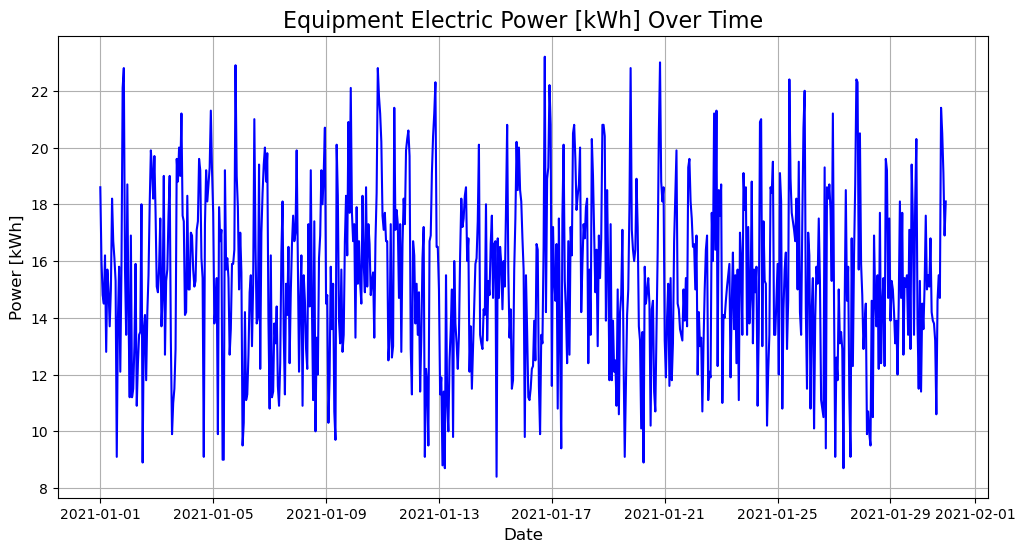

In [159]:


plt.figure(figsize=(12, 6))

plt.plot(df_b5.index[:24*30], df_b5['Equipment Electric Power [kWh]'][:24*30], label='Equipment Electric Power [kWh]', color='blue')




plt.title('Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)

plt.grid(True)

plt.show()

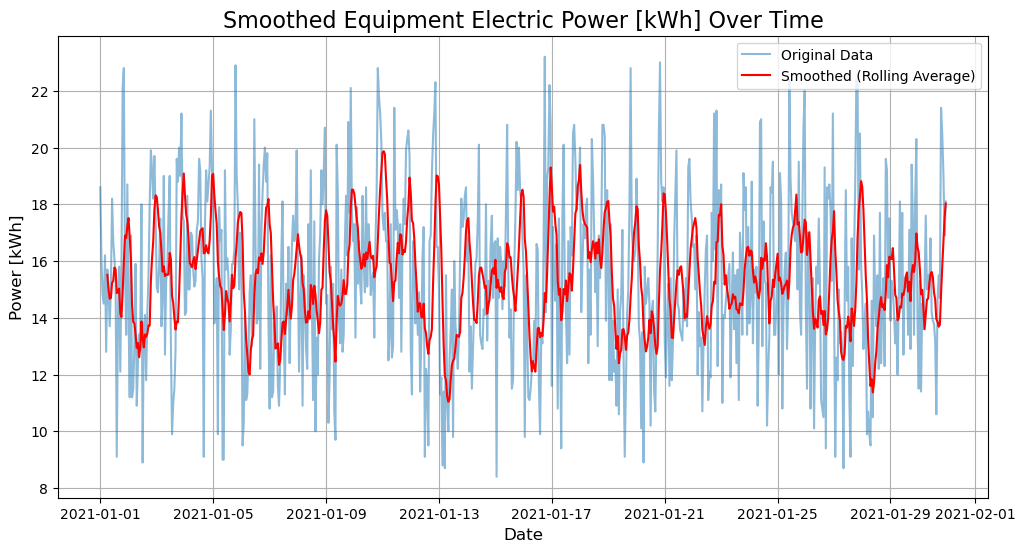

In [160]:
df_b5['Smoothed'] = df_5['Equipment Electric Power [kWh]'].rolling(window=7).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df_b5.index[:24*30], df_b5['Equipment Electric Power [kWh]'][:24*30], label='Original Data', alpha=0.5)
plt.plot(df_b5.index[:24*30], df_b5['Smoothed'][:24*30], label='Smoothed (Rolling Average)', color='red')

plt.title('Smoothed Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

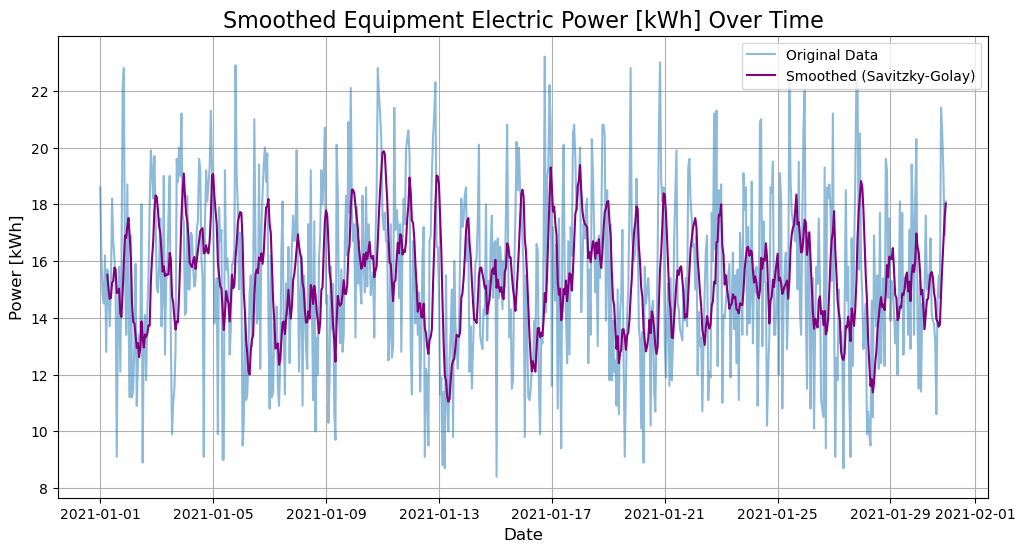

In [161]:


df_b5['Smoothed1'] = savgol_filter(df_b5['Equipment Electric Power [kWh]'], window_length=11, polyorder=2)

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df_b5.index[:24*30], df_b5['Equipment Electric Power [kWh]'][:24*30], label='Original Data', alpha=0.5)
plt.plot(df_b5.index[:24*30], df_b5['Smoothed'][:24*30], label='Smoothed (Savitzky-Golay)', color='purple')

plt.title('Smoothed Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

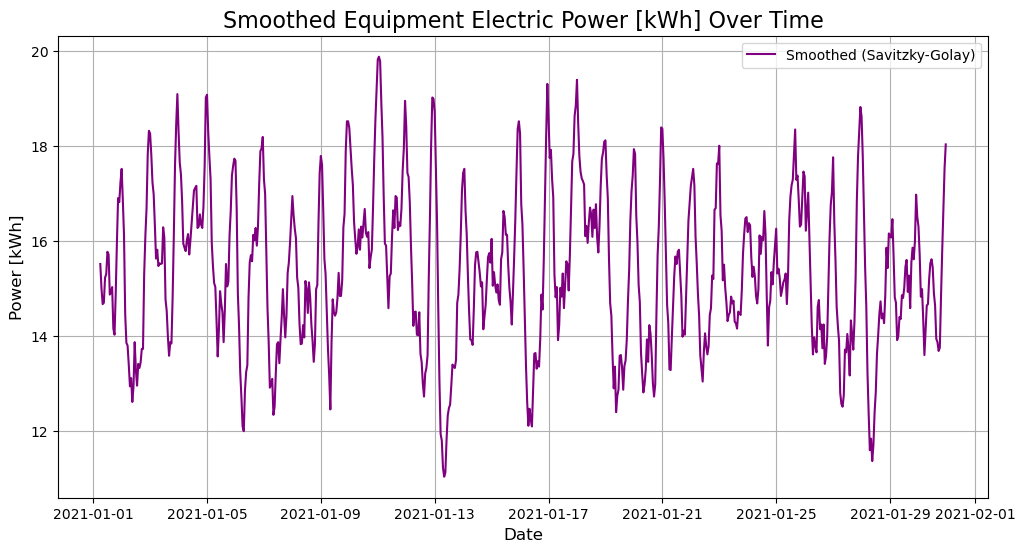

In [162]:

df_b5['Smoothed1'] = savgol_filter(df_b5['Equipment Electric Power [kWh]'], window_length=11, polyorder=2)

# Plot the smoothed data
plt.figure(figsize=(12, 6))

plt.plot(df_b5.index[:24*30], df_b5['Smoothed'][:24*30], label='Smoothed (Savitzky-Golay)', color='purple')

plt.title('Smoothed Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

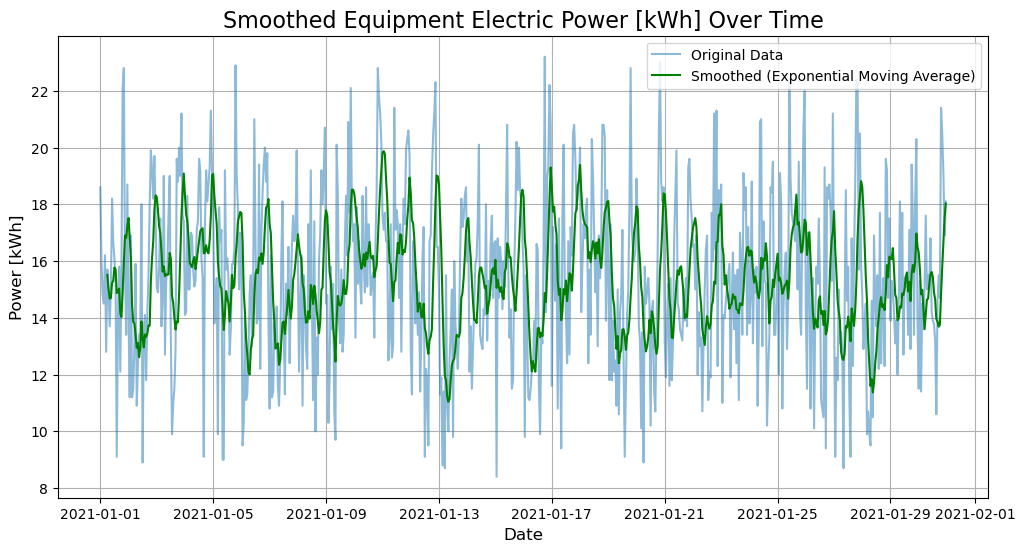

In [163]:
df_b5['Smoothed2'] = df_b5['Equipment Electric Power [kWh]'].ewm(span=10, adjust=False).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df_b5.index[:24*30], df_b5['Equipment Electric Power [kWh]'][:24*30], label='Original Data', alpha=0.5)
plt.plot(df_b5.index[:24*30], df_b5['Smoothed'][:24*30], label='Smoothed (Exponential Moving Average)', color='green')

plt.title('Smoothed Equipment Electric Power [kWh] Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [164]:
## Correlations

correlation_matrix = df_b5.corr()

target_correlation = correlation_matrix['Smoothed1']

sorted_correlation = target_correlation.sort_values(ascending=False)

print(sorted_correlation)

Smoothed1                                        1.000000
Smoothed2                                        0.790656
Equipment Electric Power [kWh]                   0.759982
Smoothed                                         0.694462
Hour                                             0.498407
6hPrediction OutdoorRelativeHumidity             0.241219
12hPredictionDirectSolarRadiation                0.180096
DHW Heating [kWh]                                0.172964
12hPredictionDiffuseSolarRadiation               0.170456
Day Type                                         0.103591
12hPredictionOutdoorRelativeHumidity             0.040289
24hPredictionOutdoorRelativeHumidity            -0.038879
kg_CO2/kWh                                      -0.044718
OutdoorRelativeHumidity                         -0.053166
Indoor Temperature [C]                          -0.078331
Month                                           -0.141020
Cooling Load [kWh]                              -0.159805
DirectSolarRad

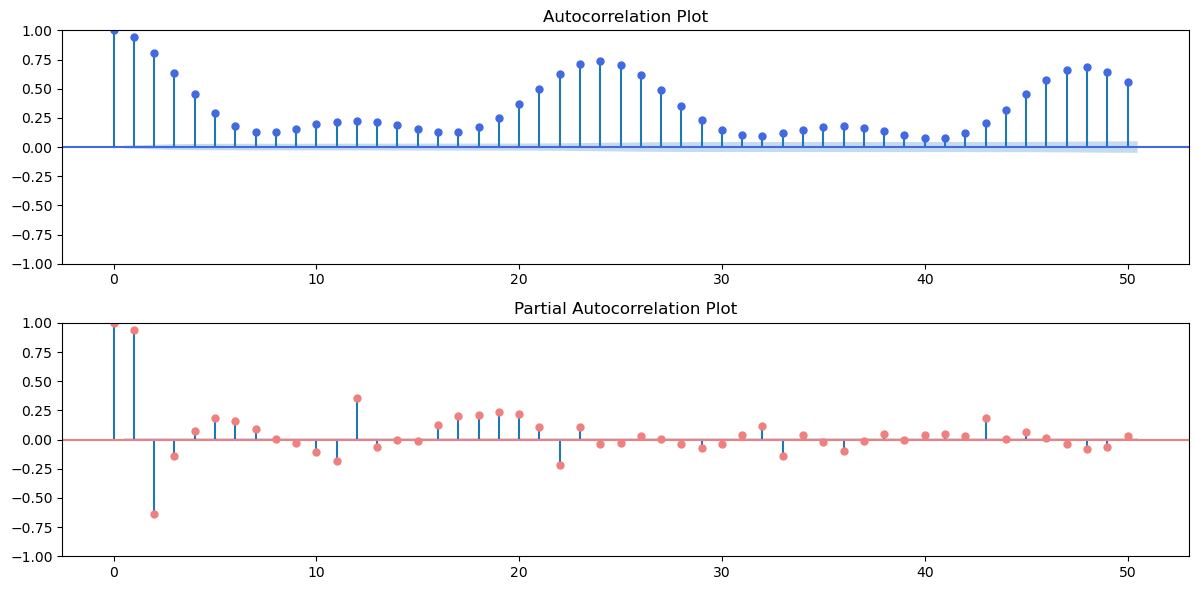

In [165]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_b5['Smoothed1'], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(df_b5['Smoothed1'], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

## Feature Engineering

In [166]:
# Add lag features based on PACF/ACF analysis
df_b5['lag_1'] = df_b5['Smoothed1'].shift(1)
df_b5['lag_2'] = df_b5['Smoothed1'].shift(2)
df_b5['lag_5'] = df_b5['Smoothed1'].shift(5)
df_b5['lag_6'] = df_b5['Smoothed1'].shift(6)
df_b5['lag_7'] = df_b5['Smoothed1'].shift(7)
df_b5['lag_8'] = df_b5['Smoothed1'].shift(8)
df_b5['lag_9'] = df_b5['Smoothed1'].shift(9)
df_b5['lag_14'] = df_b5['Smoothed1'].shift(14)


df_b5['lag_18'] = df_b5['Smoothed1'].shift(18)
df_b5['lag_19'] = df_b5['Smoothed1'].shift(19)
df_b5['lag_20'] = df_b5['Smoothed1'].shift(20)
df_b5['lag_21'] = df_b5['Smoothed1'].shift(21)


df_b5['lag_22'] = df_b5['Smoothed1'].shift(22)
df_b5['lag_23'] = df_b5['Smoothed1'].shift(23)
df_b5['lag_25'] = df_b5['Smoothed1'].shift(25)
df_b5['lag_36'] = df_b5['Smoothed1'].shift(36)




# Add rolling statistics (mean and std) over a 7-day window
df_b5['rolling_mean_7'] = df_b5['Smoothed1'].rolling(window=7).mean()
df_b5['rolling_std_7'] = df_b5['Smoothed1'].rolling(window=7).std()

# Rolling and lagged features for DHW Heating [kWh]
df_b5["12hPredictionOutdoorRelativeHumidity_rolling_mean_24"] = df_b5["12hPredictionOutdoorRelativeHumidity"].rolling(window=24).mean()
df_b5["12hPredictionOutdoorRelativeHumidity_lag_1"] = df_b5["12hPredictionOutdoorRelativeHumidity"].shift(1)

# Rolling and lagged features for DHW Heating [kWh]
df_b5["12hPredictionDirectSolarRadiation_mean_24"] = df_b5["12hPredictionDirectSolarRadiation"].rolling(window=24).mean()
df_b5["12hPredictionDirectSolarRadiation_lag_1"] = df_b5["12hPredictionDirectSolarRadiation"].shift(1)






# Add sine/cosine encoding for hour of day and month of the year
df_b5["hour_x"] = np.sin(np.radians((360/24) * df_b5.index.hour))
df_b5["hour_y"] = np.cos(np.radians((360/24) * df_b5.index.hour))
df_b5["month_x"] = np.sin(np.radians((360/12) * df_b5.index.month))
df_b5["month_y"] = np.cos(np.radians((360/12) * df_b5.index.month))

# Add calendar-based variables as categorical data
#df_b5['hour'] = df_b5.index.hour  # Hour of the day
df_b5['dayofweek'] = df_b5.index.dayofweek  # Day of the week
df_b5['quarter'] = df_b5.index.quarter  # Quarter of the year
#df_b5['month'] = df_b5.index.month  # Month of the year
df_b5['year'] = df_b5.index.year  # Year
df_b5['dayofyear'] = df_b5.index.dayofyear  # Day of the year
df_b5['dayofmonth'] = df_b5.index.day  # Day of the month
df_b5['weekofyear'] = df_b5.index.isocalendar().week  # Week of the year


window = df_b5['Smoothed1'].expanding()

dataframe = pd.concat([window.min(), window.mean(), window.max(), df_b5['Smoothed1'].shift(-1)], axis=1)

dataframe.columns = ['min_5', 'mean_5', 'max_5', 't+1_5']


df_b5 = pd.concat([dataframe, df_b5 ], axis=1)

df_b5.shape


(26280, 63)

df_b5 = df_b5.drop(columns=['Smoothed', 'Smoothed2', 'Equipment Electric Power [kWh]','Average Unmet Cooling Setpoint Difference [C]'])

In [167]:
df_b5.isnull().sum()
df_b5 = df_b5.dropna()

In [168]:
df_b5.shape

(26243, 63)

In [169]:
df_b5.head()

,min_5,mean_5,max_5,t+1_5,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],...,hour_x,hour_y,month_x,month_y,dayofweek,quarter,year,dayofyear,dayofmonth,weekofyear
time,,,,,,,,,,,,,,,,,,,,,
2021-01-02 12:00:00,12.528671,14.855106,18.499534,13.014219,1.0,13.0,5.0,0.0,23.11,0.0,...,1.224647e-16,-1.000000,0.5,0.866025,5,1,2021,2,2,53
2021-01-02 13:00:00,12.528671,14.806662,18.499534,12.916317,1.0,14.0,5.0,0.0,23.11,0.0,...,-2.588190e-01,-0.965926,0.5,0.866025,5,1,2021,2,2,53
2021-01-02 14:00:00,12.528671,14.758191,18.499534,13.479720,1.0,15.0,5.0,0.0,23.11,0.0,...,-5.000000e-01,-0.866025,0.5,0.866025,5,1,2021,2,2,53
2021-01-02 15:00:00,12.528671,14.726230,18.499534,14.441958,1.0,16.0,5.0,0.0,23.11,0.0,...,-7.071068e-01,-0.707107,0.5,0.866025,5,1,2021,2,2,53
2021-01-02 16:00:00,12.528671,14.719296,18.499534,16.301632,1.0,17.0,5.0,0.0,23.11,0.0,...,-8.660254e-01,-0.500000,0.5,0.866025,5,1,2021,2,2,53


In [170]:
df_b5.columns

Index(['min_5', 'mean_5', 'max_5', 't+1_5', 'Month', 'Hour', 'Day Type',
       'Daylight Savings Status', 'Indoor Temperature [C]',
       'Average Unmet Cooling Setpoint Difference [C]',
       'Indoor Relative Humidity [%]', 'Equipment Electric Power [kWh]',
       'DHW Heating [kWh]', 'Cooling Load [kWh]', 'OutdoorDrybulbTemperature',
       'OutdoorRelativeHumidity', 'DiffuseSolarRadiation',
       'DirectSolarRadiation', '6hPrediction OutdoorRelativeHumidity',
       '12hPredictionOutdoorRelativeHumidity',
       '24hPredictionOutdoorRelativeHumidity',
       '6hPredictionDiffuseSolarRadiation',
       '12hPredictionDiffuseSolarRadiation',
       '24hPredictionDiffuseSolarRadiation',
       '6hPredictionDirectSolarRadiation', '12hPredictionDirectSolarRadiation',
       '24hPredictionDirectSolarRadiation', 'kg_CO2/kWh', 'Smoothed',
       'Smoothed1', 'Smoothed2', 'lag_1', 'lag_2', 'lag_5', 'lag_6', 'lag_7',
       'lag_8', 'lag_9', 'lag_14', 'lag_18', 'lag_19', 'lag_20', 'lag_21'

In [171]:
# List of building dataframes and corresponding names for saving the files
building_dataframes = [df_b1, df_b2, df_b3, df_b4, df_b6, df_b7, df_b8, df_b9]
building_names = ["df_b1", "df_b2", "df_b3", "df_b4", "df_b6", "df_b7", "df_b8", "df_b9"]

# Save each dataframe as a CSV file, preserving the index
for df, name in zip(building_dataframes, building_names):
    df.to_csv(f"{name}_sliced.csv", index=True)  # Save with the index retained
#df_b1 = pd.read_csv("df_b1_sliced.csv", index_col=0)

## Feature Selection for Building 5

In [172]:

X = df_b5.drop(['Smoothed1'], axis = 1)
y= df_b5[['Smoothed1']]


In [173]:
y.shape

(26243, 1)

In [174]:
params_pca = {'cum_variance' : 0.90, 'if_apply' : True }
X_pca = apply_PCA(X, **params_pca)
X_pca.shape

(26243, 19)

In [175]:
y.shape

(26243, 1)

In [176]:
train_cutoff = int(0.8*X_pca.shape[0])
val_cutoff   = int(0.9*X_pca.shape[0])

scaler_y = MinMaxScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)

In [177]:
data_norm = np.concatenate((X_pca,y_norm), axis = 1)

In [178]:
# History size and horizon size
hist_size = 24
horizon_size = 24

# Get the windows
#data, labels = windowing(X_input, y_input, history_size, horizon_size)
X_train, y_train = windowing(data_norm[:train_cutoff,:],data_norm[:train_cutoff,-1], hist_size, horizon_size)
X_val, y_val     = windowing(data_norm[train_cutoff :val_cutoff,:],data_norm[train_cutoff:val_cutoff,-1], hist_size, horizon_size)
X_test, y_test   = windowing(data_norm[val_cutoff :,:],data_norm[val_cutoff:,-1], hist_size, horizon_size)

In [179]:
print('X_train is:', X_train.shape)
print('y_train is:', y_train.shape)
print('X_val is:', X_val.shape)
print('y_val is:', y_val.shape)
print('X_test is:', X_test.shape)
print('y_test is:', y_test.shape)


X_train is: (20947, 24, 20)
y_train is: (20947, 24)
X_val is: (2577, 24, 20)
y_val is: (2577, 24)
X_test is: (2578, 24, 20)
y_test is: (2578, 24)


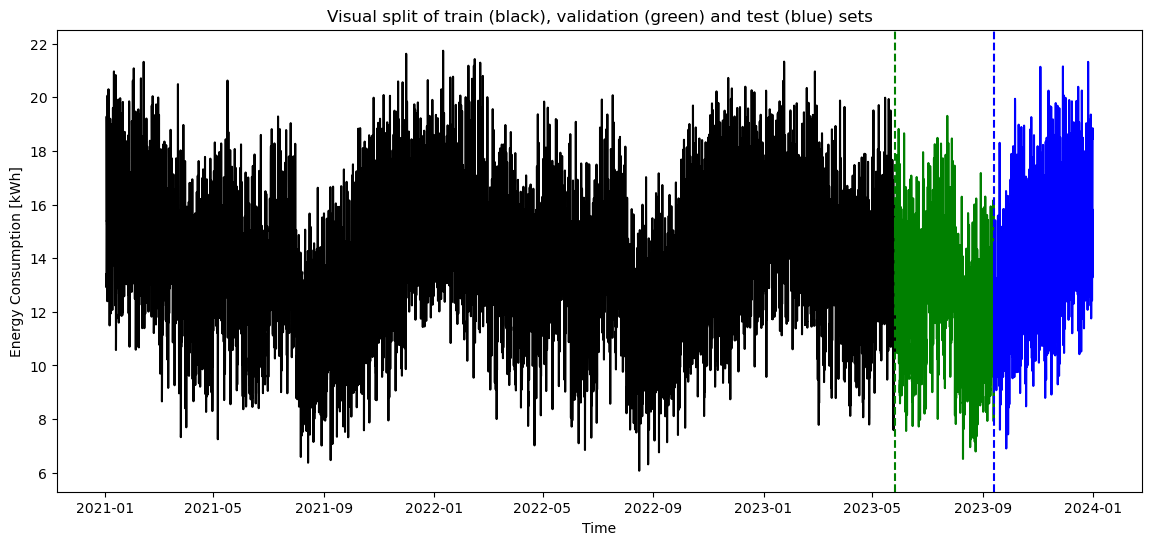

In [180]:
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df_b5['Smoothed1'].iloc[:train_cutoff], color = 'black')
axes.plot(df_b5['Smoothed1'].iloc[train_cutoff + 1 : val_cutoff], color = 'green')
axes.plot(df_b5['Smoothed1'].iloc[val_cutoff + 1 :], color = 'blue')
axes.axvline(x=df_b5.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=df_b5.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Time')
axes.set_ylabel('Energy Consumption [kWh]')
plt.show()


## NEW XGBoost

## Forecasting
## 1. XGBoost

In [181]:
X_train_xgb = reshaping(X_train)
X_val_xgb   = reshaping(X_val)
X_test_xgb  = reshaping(X_test)

In [182]:
X_train_xgb.shape

(20947, 480)

In [183]:
X_val_xgb.shape

(2577, 480)

In [184]:
X_test_xgb.shape

(2578, 480)

In [185]:
! pip3 install optuna

In [186]:
##### # Convert your dataset into DMatrix (required by XGBoost for training)
dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
dval = xgb.DMatrix(X_val_xgb, label=y_val)
dtest = xgb.DMatrix(X_test_xgb)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'alpha': trial.suggest_float('alpha', 0.001, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 0.001, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.001, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=5000,
        evals=[(dtrain, 'train'), (dval, 'eval')],
        early_stopping_rounds=50,
        evals_result=evals_result,
        verbose_eval=False
    )

    # Predict on the validation set
    preds = model.predict(dval)

    # Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_val, preds)

    return mae


In [187]:
# Start the timer for tuning with Optuna
start = time.time()

# Create an Optuna study object and optimize it
study = optuna.create_study(direction='minimize')  # We want to minimize the MAE
study.optimize(objective, n_trials=100, timeout=600)  # Optimize for 50 trials or 10 minutes

end = time.time()

# Print Optuna tuning duration
print(f"Optuna tuning completed in {end - start:.2f} seconds")

# Print the best parameters and MAE found by Optuna
print(f"Best MAE: {study.best_value}")
print(f"Best hyperparameters: {study.best_params}")

# Set the best parameters for the final model
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'mae'

[I 2024-12-22 22:30:55,719] A new study created in memory with name: no-name-c54f87e3-8245-4b74-afcf-6cdd7f06d6bf
[I 2024-12-22 23:52:22,586] Trial 0 finished with value: 0.06262976263321955 and parameters: {'alpha': 0.18514665771943184, 'lambda': 0.08755641977371396, 'gamma': 0.0015191703560100468, 'colsample_bytree': 0.8671946419369512, 'learning_rate': 0.03310731807916888, 'max_depth': 50, 'min_child_weight': 3, 'subsample': 0.572557170167608}. Best is trial 0 with value: 0.06262976263321955.


Optuna tuning completed in 4886.88 seconds
Best MAE: 0.06262976263321955
Best hyperparameters: {'alpha': 0.18514665771943184, 'lambda': 0.08755641977371396, 'gamma': 0.0015191703560100468, 'colsample_bytree': 0.8671946419369512, 'learning_rate': 0.03310731807916888, 'max_depth': 50, 'min_child_weight': 3, 'subsample': 0.572557170167608}


In [188]:
final_params = best_params.copy()

In [189]:
# Start the timer for the final training
start = time.time()
evals_result = {}

# Train the final model using the best parameters found by Optuna
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=200,
    evals_result=evals_result,
    verbose_eval=50,
    
)

# End the timer for final training
end = time.time()

# Output the final model training runtime
print("Run time [s] for the final XGBoost model is: ", end - start, " Seconds")

[0]	train-mae:0.12498	eval-mae:0.14232
[50]	train-mae:0.04019	eval-mae:0.07185
[100]	train-mae:0.02025	eval-mae:0.06442
[150]	train-mae:0.01403	eval-mae:0.06315
[200]	train-mae:0.01152	eval-mae:0.06280
[250]	train-mae:0.01039	eval-mae:0.06269
[300]	train-mae:0.00987	eval-mae:0.06266
[350]	train-mae:0.00966	eval-mae:0.06264
[400]	train-mae:0.00953	eval-mae:0.06263
[450]	train-mae:0.00946	eval-mae:0.06263
[500]	train-mae:0.00940	eval-mae:0.06262
[550]	train-mae:0.00935	eval-mae:0.06262
[600]	train-mae:0.00932	eval-mae:0.06262
[650]	train-mae:0.00929	eval-mae:0.06262
[700]	train-mae:0.00926	eval-mae:0.06262
[750]	train-mae:0.00924	eval-mae:0.06262
[800]	train-mae:0.00922	eval-mae:0.06261
[850]	train-mae:0.00920	eval-mae:0.06261
[900]	train-mae:0.00919	eval-mae:0.06261
[950]	train-mae:0.00917	eval-mae:0.06261
[1000]	train-mae:0.00916	eval-mae:0.06261
[1050]	train-mae:0.00915	eval-mae:0.06261
[1100]	train-mae:0.00914	eval-mae:0.06261
[1150]	train-mae:0.00913	eval-mae:0.06261
[1200]	train-ma

In [190]:
y_pred = final_model.predict(dtest) 


---------------------------------------------------
TL_model_loaded MAE for test set : 0.991
TL_model_loaded MSE for test set : 1.578
TL_model_loaded RMSE for test set : 1.256
TL_model_loaded MPE for test set : -1.231 %
TL_model_loaded MAPE for test set : 7.44 %
---------------------------------------------------



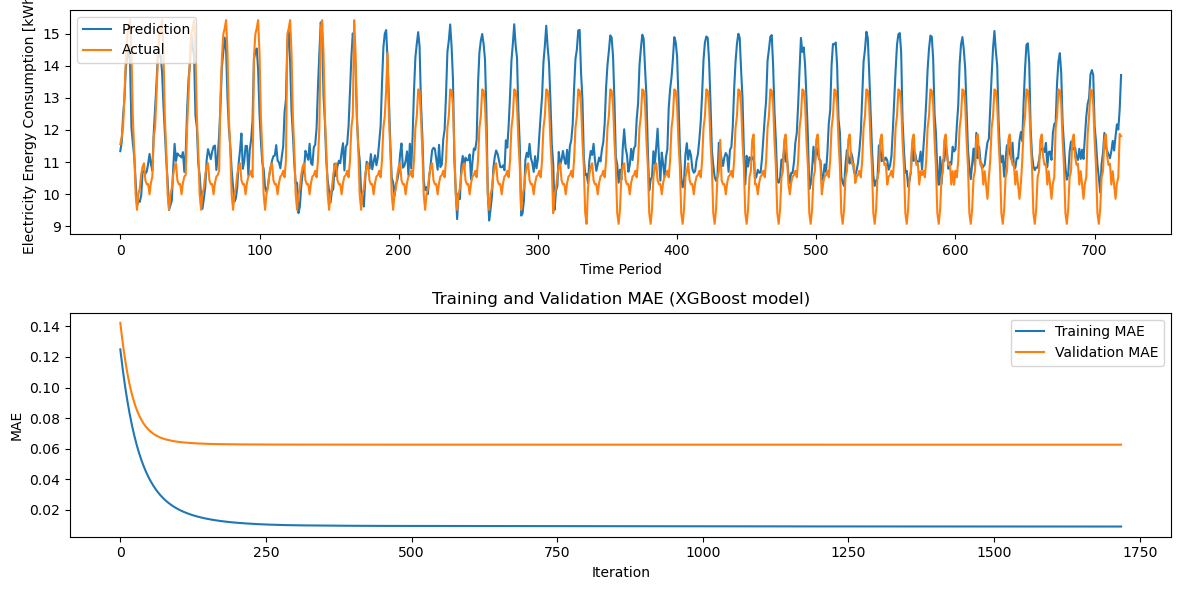

In [192]:
# Inverse transform the predictions and the test data (if scaled)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Ensure shape is (-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_actual)
mae = mean_absolute_error(y_test_inv, y_pred_actual)
rmse = np.sqrt(mse)
mpe = np.mean((y_test_inv - y_pred_actual) / y_test_inv) * 100

# Calculate MAPE
mape = np.mean(np.abs((y_test_inv - y_pred_actual) / y_test_inv)) * 100

# Print the evaluation metrics
print('')
print('---------------------------------------------------')
print(f'TL_model_loaded MAE for test set : {round(mae, 3)}')
print(f'TL_model_loaded MSE for test set : {round(mse, 3)}')
print(f'TL_model_loaded RMSE for test set : {round(rmse, 3)}')
print(f'TL_model_loaded MPE for test set : {round(mpe, 3)} %')
print(f'TL_model_loaded MAPE for test set : {round(mape, 3)} %')
print('---------------------------------------------------')
print('')

# Call the plot_results_xgboost function
plot_results_xgboost(y_pred_actual, y_test_inv, evals_result, 'XGBoost model')


In [193]:
# Save the model as a JSON file
final_model.save_model('Building_7NEW_model_cluster3.json')
print("Model saved as 'xgboost_final_model1.json'")

Model saved as 'xgboost_final_model1.json'


In [67]:
#@@@@@@@@@@@@@@@@@

## 2.Random Forest Regressor

In [196]:
# Define the training function
def random_forest_train(params, X_train, y_train, X_val, y_val):
    model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        random_state=42,
    )
    # Train the model
    model.fit(X_train, y_train)

    # Predict on validation set
    preds = model.predict(X_val)

    # Calculate validation MAE
    mae = mean_absolute_error(y_val, preds)
    return model, mae



In [198]:
# Define the objective function for Optuna
def objective(trial):
    
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100, step=5),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),  # Removed 'auto'
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    # Train the model and get validation MAE
    _, mae = random_forest_train(params, X_train_xgb, y_train, X_val_xgb, y_val)
    return mae

# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

# Print best trial results
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2024-12-23 00:56:20,073] A new study created in memory with name: no-name-6093b85c-ecd9-4d5f-b093-5362d270c881
[I 2024-12-23 00:56:29,977] Trial 0 finished with value: 0.07326944884149447 and parameters: {'n_estimators': 55, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.07326944884149447.
[I 2024-12-23 01:03:10,996] Trial 1 finished with value: 0.08266000348277688 and parameters: {'n_estimators': 75, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.07326944884149447.
[I 2024-12-23 01:03:25,626] Trial 2 finished with value: 0.06963762897351604 and parameters: {'n_estimators': 75, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.06963762897351604.
[I 2024-12-23 01:09:48,114] Trial 3 finished with value: 0.0623910965170463

Best trial:
  Value: 0.06239109651704633
  Params: 
    n_estimators: 75
    max_depth: 9
    min_samples_split: 3
    min_samples_leaf: 10
    max_features: None
    bootstrap: True


In [199]:
# Train the final model with the best parameters
# Start the timer for the final training
start = time.time()

best_params = study.best_trial.params
rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    random_state=42,
)

# Train the model on the full training data
rf_model.fit(X_train_xgb, y_train)
# End the timer for final training
end = time.time()

# Output the final model training runtime
print("Run time [s] for the final RandomForest model is: ", end - start, " Seconds")

Run time [s] for the final RandomForest model is:  389.96200728416443  Seconds


In [200]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test_xgb)



---------------------------------------------------
RandomForest MAE for test set: 1.011
RandomForest MSE for test set: 1.622
RandomForest RMSE for test set: 1.274
TL_model_loaded MPE for test set : -0.283 %
TL_model_loaded MAPE for test set : 7.533 %
---------------------------------------------------



NameError: name 'history' is not defined

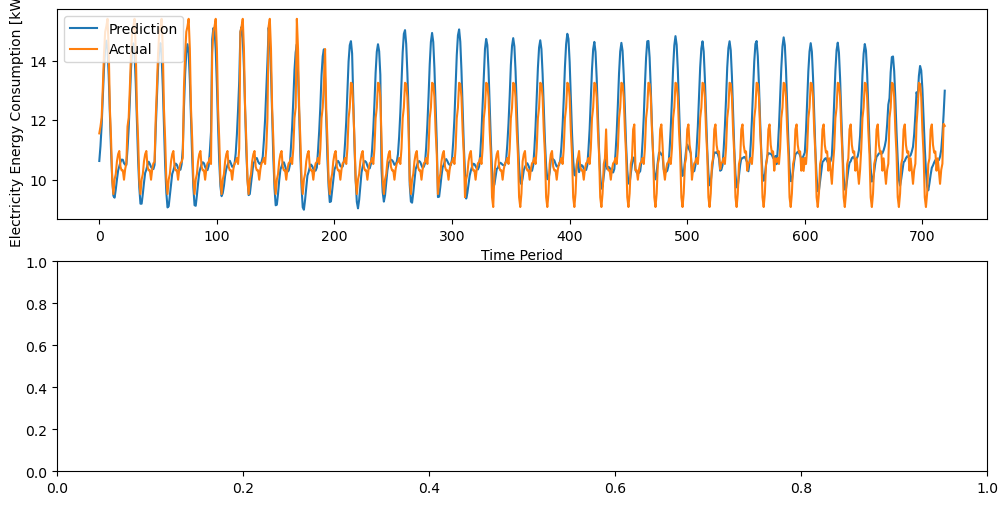

In [204]:

# Make predictions on the test set using RandomForest
y_pred = rf_model.predict(X_test_xgb) 

# Inverse transform the predictions and the test data (if scaled)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Ensure shape is (-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Ensure shape is (-1, 1)

# Calculate the metrics using the inverse-transformed values
mse = mean_squared_error(y_test_inv, y_pred_actual)
mae = mean_absolute_error(y_test_inv, y_pred_actual)
rmse = np.sqrt(mse)
# Calculate MPE (Mean Percentage Error)
mpe = np.mean((y_test_inv - y_pred_actual) / y_test_inv) * 100  # Mean percentage error
# Calculate MAPE
mape = np.mean(np.abs((y_test_inv - y_pred_actual) / y_test_inv)) * 100

# Print out the metrics
print('')
print('')
print('---------------------------------------------------')
print(f'RandomForest MAE for test set: {round(mae, 3)}')
print(f'RandomForest MSE for test set: {round(mse, 3)}')
print(f'RandomForest RMSE for test set: {round(rmse, 3)}')
print(f'TL_model_loaded MPE for test set : {round(mpe, 3)} %')
print(f'TL_model_loaded MAPE for test set : {round(mape, 3)} %')
print('---------------------------------------------------')
print('')

# Call the plot_results function for plotting
plot_results(y_pred_actual, y_test_inv, rf_model, 'RandomForest')


In [ ]:
X_train_xgb = reshaping(X_train)
X_val_xgb   = reshaping(X_val)
X_test_xgb  = reshaping(X_test)

In [ ]:
X_train_xgb.shape

In [ ]:
X_val_xgb.shape

In [ ]:
X_test_xgb.shape

In [ ]:
y_val.shape

In [ ]:


# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)

start = time.time()

# Train the Random Forest model
rf_model.fit(X_train_xgb, y_train)


end = time.time()

print("Run time [s] for RandomForestRegressor model is: ",end-start, " Seconds")

In [ ]:


# Make predictions on the test set using RandomForest
y_pred = rf_model.predict(X_test_xgb) 

# Inverse transform the predictions and the test data (if scaled)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Ensure shape is (-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Ensure shape is (-1, 1)

# Calculate the metrics using the inverse-transformed values
mse = mean_squared_error(y_test_inv, y_pred_actual)
mae = mean_absolute_error(y_test_inv, y_pred_actual)
rmse = np.sqrt(mse)
# Calculate MPE (Mean Percentage Error)
mpe = np.mean((y_test_inv - y_pred_actual) / y_test_inv) * 100  # Mean percentage error
# Calculate MAPE
mape = np.mean(np.abs((y_test_inv - y_pred_actual) / y_test_inv)) * 100

# Print out the metrics
print('')
print('')
print('---------------------------------------------------')
print(f'RandomForest MAE for test set: {round(mae, 3)}')
print(f'RandomForest MSE for test set: {round(mse, 3)}')
print(f'RandomForest RMSE for test set: {round(rmse, 3)}')
print(f'TL_model_loaded MPE for test set : {round(mpe, 3)} %')
print(f'TL_model_loaded MAPE for test set : {round(mape, 3)} %')
print('---------------------------------------------------')
print('')

# Call the plot_results function for plotting
plot_results(y_pred_actual, y_test_inv, rf_model, 'RandomForest')


## 3. LSTM

In [107]:


def base_model_lstm():
    model = Sequential()
    
    # LSTM layer (no need for return_sequences=True since we predict at the final time step)
    model.add(LSTM(units=64, activation="relu", input_shape=X_train.shape[-2:]))
    
    # Dense layers for prediction (output 24 values for the next 24 hours)
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=24))  # Output 24 units for 24-hour prediction
    
    return model

# Instantiate the model
lstm_model = base_model_lstm()

# Compile the model with an optimizer and loss function (for regression)
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Model summary
lstm_model.summary()

2024-12-22 09:05:56.953497: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,176 (129.59 KB)

 Trainable params: 33,176 (129.59 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
optimizer = Adam(learning_rate=0.01, amsgrad=True)
batch_size = 32
epoch = 500

In [109]:
start = time.time()


history = lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

end = time.time()
print("Run time [s] for XGBRegressor model is: ",end-start, " Seconds")

Epoch 1/500
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0376 - mae: 0.1364 - val_loss: 0.0080 - val_mae: 0.0702
Epoch 2/500
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0084 - mae: 0.0729 - val_loss: 0.0078 - val_mae: 0.0692
Epoch 3/500
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0074 - mae: 0.0685 - val_loss: 0.0072 - val_mae: 0.0667
Epoch 4/500
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0069 - mae: 0.0657 - val_loss: 0.0074 - val_mae: 0.0678
Epoch 5/500
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0063 - mae: 0.0629 - val_loss: 0.0082 - val_mae: 0.0709
Epoch 6/500
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0059 - mae: 0.0608 - val_loss: 0.0071 - val_mae: 0.0662
Epoch 7/500
655/655 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0055 - mae: 0.0589 - val_loss: 0.0063 - val_mae: 0.0625
Epoch 8/500
655/655 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0052 - mae: 0.0570 - val_loss: 0.0065 - val_mae: 0.0635
Epoch 9/500
655/655 ━━━━━━━━━━━━━━

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


---------------------------------------------------
RandomForest MAE for test set: 1.101
RandomForest MSE for test set: 1.932
RandomForest RMSE for test set: 1.39
TL_model_loaded MPE for test set : -0.12 %
TL_model_loaded MAPE for test set : 8.109 %
---------------------------------------------------



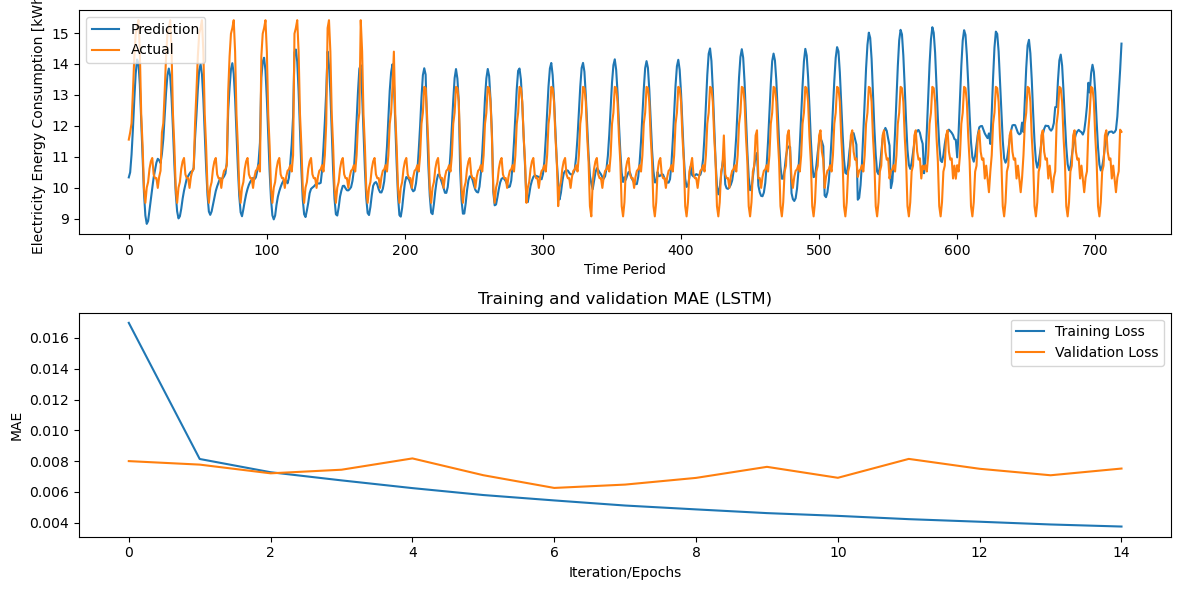

In [110]:
y_pred = lstm_model.predict(X_test)
# Inverse transform the predictions and the test data (if scaled)
# Inverse transform the predictions and the test data (if scaled)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Ensure shape is (-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Ensure shape is (-1, 1)

# Calculate the metrics using the inverse-transformed values
mse = mean_squared_error(y_test_inv, y_pred_actual)
mae = mean_absolute_error(y_test_inv, y_pred_actual)
rmse = np.sqrt(mse)
# Calculate MPE (Mean Percentage Error)
mpe = np.mean((y_test_inv - y_pred_actual) / y_test_inv) * 100  # Mean percentage error
mape = np.mean(np.abs((y_test_inv - y_pred_actual) / y_test_inv)) * 100
# Print out the metrics
print('')
print('')
print('---------------------------------------------------')
print(f'RandomForest MAE for test set: {round(mae, 3)}')
print(f'RandomForest MSE for test set: {round(mse, 3)}')
print(f'RandomForest RMSE for test set: {round(rmse, 3)}')
print(f'TL_model_loaded MPE for test set : {round(mpe, 3)} %')
print(f'TL_model_loaded MAPE for test set : {round(mape, 3)} %')
print('---------------------------------------------------')
print('')

# Call the plot_results function for plotting

plot_results(y_pred_actual, y_test_inv, history,'LSTM')